## Survey data of personal behavior with respect to COVID--notebook contains mask specific data

- Compiled by Institute of Global Health at the Imperial College of London and YouGov

### Terms of use

- Data is copyright 2020 YouGov Plc, all rights reserved, is provided to the public strictly for educational and academic research purposes.

### Citation

- Jones, Sarah P., Imperial College London Big Data Analytical Unit and YouGov Plc. 2020, Imperial College London YouGov Covid Data Hub, v1.0, YouGov Plc, April 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Relevant mask features

#### All questions asked 4/2/20 - 9/30/20
- endtime, state, qweek
- i1_health: About how many people from your household have you come into physical contact with (within 2 meters / 6 feet)?
- i2_health: Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?
- i7a_health: How many times did you leave your home yesterday?  If you are not staying at home, how many times did you leave where you are staying yesterday?
- i12_health_1: Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)

#### Questions below begin 6/24/20--looked at these but they're mostly missing data
- m2: On how many days last week did you leave your house?
- m3: And on how many of those days did you wear a face mask or covering?
- r1_3: Wearing a mask will protect me against coronavirus (COVID-19) (1 disagree, 7 agree)
- r1_4: Wearing a mask will protect others against coronavirus (COVID-19) (1 disagree, 7 agree)
- m14_6: Masks are not effective in preventing the spread of Covid-19
- (Data did not appear in this dataset $m14: Why are you currently not wearing a mask or face covering when you go outside? Please tick all that apply)

In [17]:
df = pd.read_csv('covid-19-tracker/data/united-states.csv')

In [60]:
dfmask = df[['endtime', 'state', 'qweek', 'i1_health', 'i2_health', 'i7a_health', 'i12_health_1']]

In [61]:
dfmask.head(1)

,endtime,state,qweek,i1_health,i2_health,i7a_health,i12_health_1
0,02/04/2020 08:11,California,week 1,5,7,0,Frequently


In [62]:
dfmask['endtime'] = pd.to_datetime(dfmask['endtime'],dayfirst=True)

In [63]:
dfmask['date'] = dfmask['endtime'].dt.date
dfmask['date'].sort_values()

0        2020-04-02
399      2020-04-02
400      2020-04-02
401      2020-04-02
402      2020-04-02
            ...    
16977    2020-09-29
16978    2020-09-29
16979    2020-09-29
16980    2020-09-30
16981    2020-09-30
Name: date, Length: 16982, dtype: object

In [64]:
dfmask['month'] = dfmask['endtime'].dt.month

In [65]:
state_groupings =  pd.read_csv('data/state_abbrev.csv', thousands=',') # Load in state groupings and merge with mask data
dfmask = dfmask.merge(state_groupings, how='inner' ,left_on='state', right_on='State')
dfmask['CVD_group'] = dfmask['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
dfmask['CVD_group'] = dfmask['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
dfmask['CVD_group'] = dfmask['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
dfmask['CVD_group'] = dfmask['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [66]:
dfmask['i12_health_1'] = (dfmask['i12_health_1']
                          .apply(lambda x: 'Always/frequently' if x in ['Always','Frequently'] else x))
dfmask['i12_health_1'] = (dfmask['i12_health_1']
                          .apply(lambda x: 'Sometimes/rarely/never' if x in ['Sometimes', 'Rarely', 'Not at all'] else x))

In [67]:
i12_group_level = (dfmask[['month', 'i12_health_1', 'CVD_group', 'i7a_health']]
                   .groupby(['month', 'CVD_group', 'i12_health_1'])
                   .count()
                   .reset_index()
                   .sort_values('month'))
i12_group_level = i12_group_level.rename(columns={'i7a_health':'count','i12_health_1':'Self-reported mask usage'})

In [68]:
# Sum up the survey counts by month and by group in order to normalize the survey results for graphing
i12_month_counts = (i12_group_level
                    .groupby(['month', 'CVD_group'])
                    .sum()
                    .rename(columns={'count':'sub_totals'})
                    .reset_index())

In [70]:
i12_group_level = i12_group_level.merge(i12_month_counts, on=['month','CVD_group'])
i12_group_level['Percent'] = i12_group_level['count'] / i12_group_level['sub_totals'] * 100

In [82]:
import plotly.express as px

group_name = 'Spring outbreak'
i12_one_group = i12_group_level[i12_group_level['CVD_group'] == group_name]

fig = px.bar(i12_one_group, x="month", y="Percent", color="Self-reported mask usage", title = f'Public mask usage for {group_name} group')
# fig.write_image("img/mask.png")
fig.write_html('img/mask.html', auto_open=True)

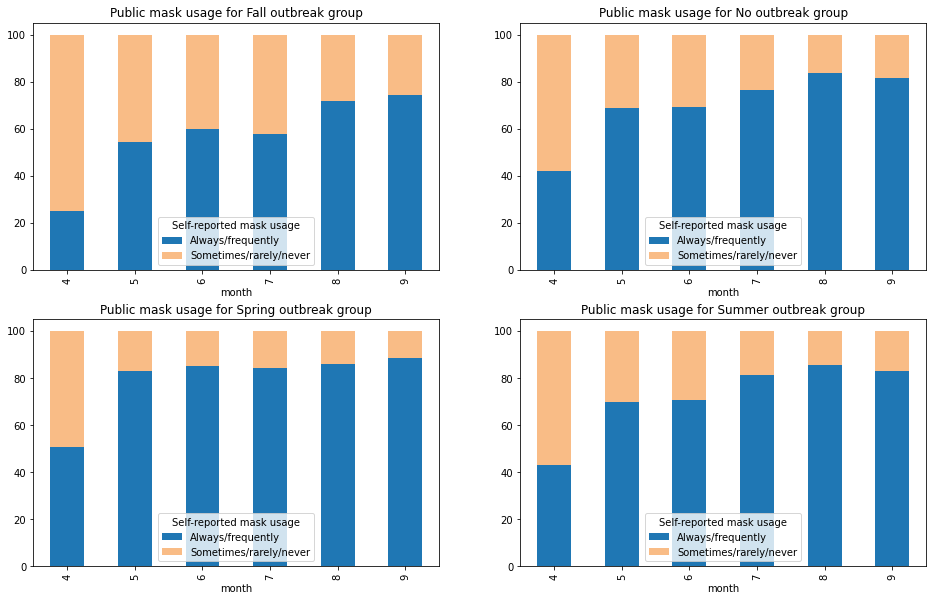

In [147]:
# Pivot table is required for converting the datatable from long format to wide format. Wide format makes the stacked bar much easier.
fig, ax = plt.subplots(2, 2, figsize = (16,10))
colors = ['tab:blue', '#f9bc86']
i = 0
for group in i12_group_level['CVD_group'].unique():
    i12_pivot = (i12_group_level[i12_group_level['CVD_group'] == group]
     .pivot(index = 'month', columns = 'Self-reported mask usage', values = 'Percent'))
    i12_pivot.loc[:,['Always/frequently','Sometimes/rarely/never']].plot.bar(stacked=True, ax=ax[i//2][i%2], color=colors)
    ax[i//2][i%2].set_title(f'Public mask usage for {group} group')
    i += 1

### Miscellaneous results: by week, by state, etc

In [66]:
dfmask['date'] = pd.to_datetime(dfmask['date'] - pd.to_timedelta(7, unit='d'))

In [75]:
i12_week = dfmask.groupby([pd.Grouper(key='date', freq='W-MON'),'i12_health_1']).count().rename(columns={'i1_health':'ct'}).reset_index().sort_values('date')
i12_week.head(1)

,date,i12_health_1,endtime,state,qweek,ct,i2_health,i7a_health,m2,m3,r1_3,r1_4,m14_6,month
0,2020-03-30,Always,374,374,374,374,374,374,374,374,374,374,374,374


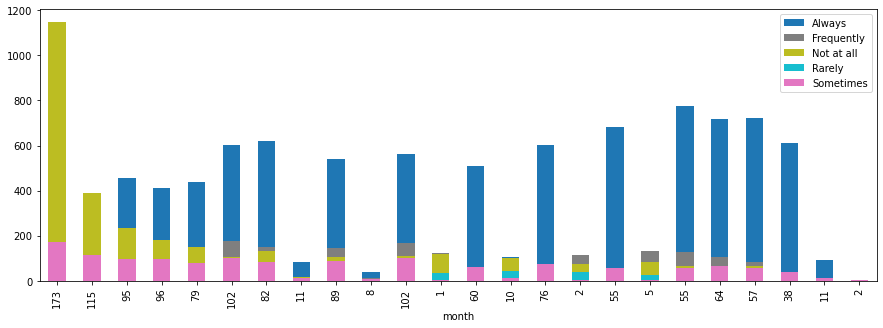

In [76]:
fig, ax = plt.subplots(figsize = (15,5))
colors = ['tab:blue', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:pink']
i = 0
for key, data in i12_week.groupby('i12_health_1'):
    data.plot.bar(x='month', y='ct', ax=ax, label=key,color = colors[i], stacked=False)
    i += 1


In [96]:
state_group = dfmask[dfmask['CVD_group'] == 0]

7663
    month i12_health_1  endtime  state  qweek   ct  i2_health  i7a_health  \
0       4       Always      715    715    715  715        715         715   
5       5       Always      842    842    842  842        842         842   
10      6       Always      462    462    462  462        462         462   
15      7       Always      629    629    629  629        629         629   
20      8       Always      693    693    693  693        693         693   
25      9       Always      605    605    605  605        605         605   

     m2   m3  ...  Population_x  CVD_group_x  State_y  Code_y  Population_y  \
0   715  715  ...           715          715      715     715           715   
5   842  842  ...           842          842      842     842           842   
10  462  462  ...           462          462      462     462           462   
15  629  629  ...           629          629      629     629           629   
20  693  693  ...           693          693      693     69

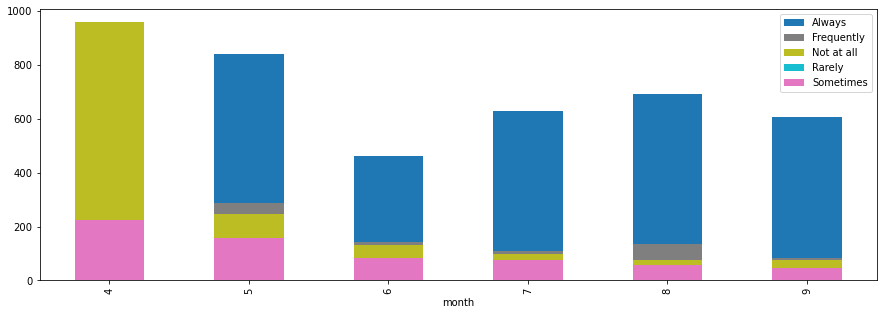

In [100]:
i12_group_month = state_group.groupby(['month','i12_health_1']).count().rename(columns={'i1_health':'ct'}).reset_index().sort_values('month')

fig, ax = plt.subplots(figsize = (15,5))
# colors = ['#00BFFF', '#C1FFC1','#FF9999', '#CAE1FF', '#FFDEAD']
colors = ['tab:blue', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:pink']
ttl_obs = i12_group_month['ct'].sum()
print(ttl_obs)
i = 0
for key, data in i12_group_month.groupby('i12_health_1'):
    print(data)
    data.plot.bar(x='month', y='ct', ax=ax, label=key,color = colors[i], stacked=False)
    i += 1